In [2]:
# Python tools for output, directory management, and graph management 
import csv
import os
from functools import partial
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from networkx import is_connected, connected_components

#gerry chain tools 
from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
    GeographicPartition,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges, Tally
from gerrychain.constraints import single_flip_contiguous
from gerrychain.accept import always_accept

graph = Graph.from_file("./Data/Wisconsin/WI_ltsb_corrected_final.shp")




/usr/local/lib/python3.7/site-packages/gerrychain/graph/graph.py:228: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1395, 63}
  "Found islands (degree-0 nodes). Indices of islands: {}".format(islands)


## Remove Islands for dirty solution to connect graph

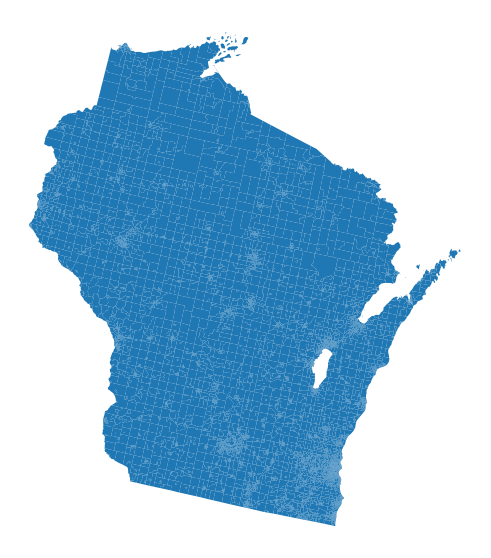

In [3]:
islands = graph.islands
components = list(connected_components(graph))
df = gpd.read_file("./Data/Wisconsin/WI_ltsb_corrected_final.shp")
df.to_crs({"init": "epsg:26986"}, inplace=True)

df.plot(figsize=(10, 10))
plt.axis('off')
plt.show()

Graph connection status:  False


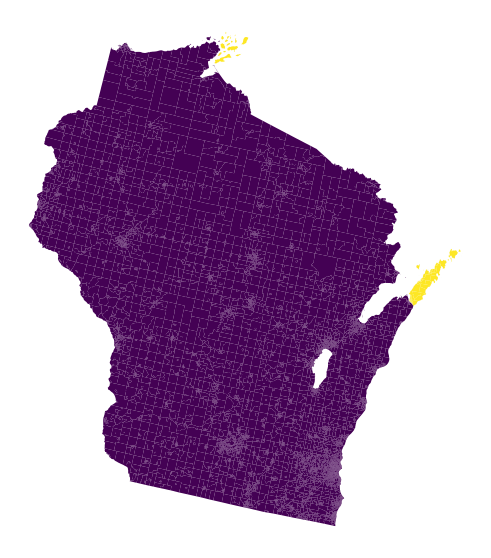

In [4]:
print("Graph connection status: ", is_connected(graph))
biggest_component_size = max(len(c) for c in components)
problem_components = [c for c in components if len(c) != biggest_component_size]
problem_nodes = [node for component in problem_components for node in component]
problem_geoids = [graph.nodes[node]["GEOID10"] for node in problem_nodes]

is_a_problem = df["GEOID10"].isin(problem_geoids)
df.plot(column=is_a_problem, figsize=(10, 10))
plt.axis('off')
plt.show()

Found the problem components! Now we delete

In [5]:
largest_component_size = max(len(c) for c in components)
to_delete = [c for c in components if len(c) != largest_component_size]
for c in to_delete:
    for node in c:
        graph.remove_node(node)

In [6]:
print("Graph connection status: ", is_connected(graph))

Graph connection status:  True


## Great! Now we proceed to set up the first Markov Chain

In [7]:
election = Election("PRETOT16", {"Dem": "PREDEM16", "Rep": "PREREP16"})
#Create initial parition based on congressional districts... not sure if this is how we want to partition?
initial_partition = Partition(
    graph,
    assignment="CON",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("PERSONS", alias="population"),
        "PRETOT16": election
    }
)

In [8]:
for district, pop in initial_partition["population"].items():
    print("District {}: {}".format(district, pop))

District 3: 710873
District 7: 710612
District 8: 693792
District 6: 710873
District 2: 710874
District 5: 710873
District 1: 710874
District 4: 710873


In [9]:
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=[single_flip_contiguous],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [10]:
d_percents = [sorted(partition["PRETOT16"].percents("Dem")) for partition in chain]

data = pd.DataFrame(d_percents)

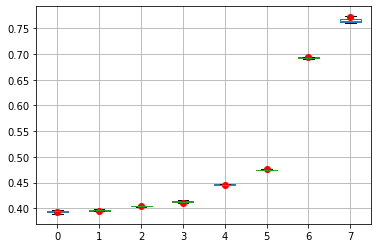

In [11]:
ax = data.boxplot(positions=range(len(data.columns)))
plt.plot(data.iloc[0], "ro")

plt.show()

# Cool! Now to move on to a more complex chain based on the Virginia house redistricing plan

In [12]:
elections = [
    Election("SEN16", {"Democratic": "USSDEM16", "Republican": "USSREP16"}),
    Election("HOS16", {"Democratic": "USHDEM16", "Republican": "USHREP16"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "PREDEM16", "Republican": "PREREP16"})
]
my_updaters = {"population": updaters.Tally("PERSONS", alias="population")}

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph, assignment="CON", updaters=my_updaters)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
# Settiing up ReCom proposal 
proposal = partial(recom,
                   pop_col="PERSONS",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

ValueError: The given initial_state is not valid according is_valid. The failed constraints were: Bounds(population,(694531.39, 722879.61))

In [ ]:
data = pd.DataFrame(
    sorted(partition["SEN12"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)